1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import trapz
from matplotlib.ticker import MaxNLocator

np.random.seed(145896)

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation

In [47]:
N=600
mean = 1.
sdev=1.
x=np.random.normal(loc=mean, scale=sdev, size = N)

* Fill an histogram in pyplot taking properly care about the aesthetic

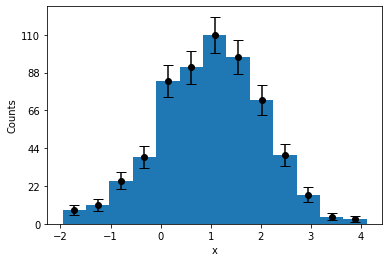

In [91]:
n, bins, _ = plt.hist(x, bins =13)
plt.ylabel("Counts")#set a proper y axis label
plt.xlabel("x")
yrange=[i*int(n.max()/5) for i in range(6)  ]
plt.yticks(yrange)#set proper value of y axis major ticks labels
#display the histograms as data points with errors 

#find the medium points of the bins and use it as x

mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='ko', capsize=5)
plt.show()


* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$

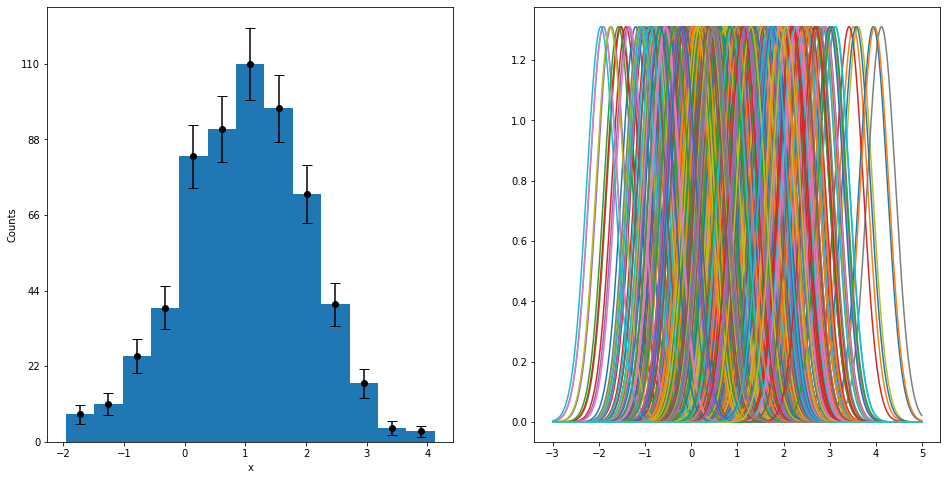

In [132]:
std = 1.06 * x.std() * x.size ** (-1/5.0)
ranges=np.arange(int(bins[0]-5*std),int(bins[len(bins)-1]+5*std),0.01)

norms=np.array([norm.pdf(ranges,loc=x[i],scale=std) for i in range(len(x)) ])
fig = plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
#old plot
n, bins, _ = plt.hist(x, bins =13)
plt.ylabel("Counts")
plt.xlabel("x")
yrange=[i*int(n.max()/5) for i in range(6)  ]
plt.yticks(yrange)
mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='ko', capsize=5)

plt.subplot(1, 2, 2)
#new plot
for i in range(len(x)) :
    plt.plot(ranges,norms[i])

plt.show()


* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the scipy.integrate.trapz() method

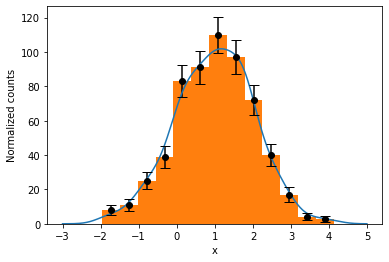

In [136]:
sums=np.sum(norms,axis=0)
integr= trapz(sums,ranges)

bin_w=bins[1] - bins[0]
int_hist = bin_w * sum(n[:])

plt.plot(ranges,sums*int_hist/integr)
plt.hist(x,bins=13)
plt.xlabel("x")
plt.ylabel("Normalized counts")
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='ko', capsize=5)

plt.show()


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 18:19:59--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-17 18:20:00--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc07ecbeebef90ae49d85c0008f0.dl.dropboxusercontent.com/cd/0/inline/BDY1BKBjGrmmDgGT605qmcXM8VXnprE5RHvvAAr6YC-sz4gOsyFgyiBi66l7DejMCQy2H4YYcoVbgDpGS7B-H2IZAvjt4Ke95JbjWTXfb2YduA/file# [segue]
--2020-11-17 18:20:00--  https://uc07ecbeebef90ae49d85c0008f0.dl.dropboxusercontent.com/cd/0/inline/BDY1BKBjGrmmDgGT605qmcXM8VXnprE5RHvvAAr6YC-sz4gOs

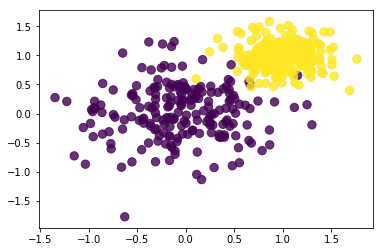

In [137]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)


In [185]:
def f(mean, cov, n, N=1000):
#parametres: means and covariance matrixs of the dataset, dimension of dataset, number of categories
    dataset=[]
    for i in range(n):
        data=np.random.multivariate_normal(mean[i], cov[i], N) 
        dataset.append(list(data))
    return dataset

* Display the dataset in a scatter plot marking the two categories with different marker colors.


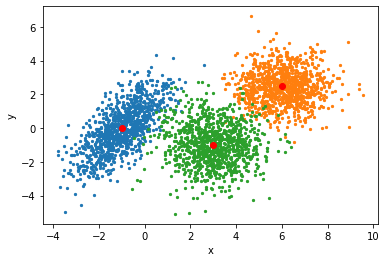

In [207]:
#example of use:
mean= [ [-1.0, 0], [6.0,2.5],[3.,-1.] ]
cov=  [ [[1.0, 1.],[1.,2.]] , [[1.1, 0],[0.,1.]] , [[1.2, 0],[0.,1.4]]] 
n=3        
data=(f(mean,cov,n))
for i in range(n):
    plt.scatter(*zip(*data[i]),5, alpha=1) # equivalent to x,y=zip(*a)
#we could make it nicer 
plt.plot(*zip(*mean),'o', color='r') #the mean of the samples is shown red
plt.xlabel('x')
plt.ylabel('y');


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [208]:
import os.path

if not os.path.isfile('data/06ex/residuals_261.npy'):
    ! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -P data/06ex/


--2020-11-17 21:42:15--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2020-11-17 21:42:16--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc2f3b8e3ed6c9452feb68283f64.dl.dropboxusercontent.com/cd/0/inline/BDZuXut1u_3HqIAsQlInfIEW9ou0bHcuxPfsQs5i4ZUx5D1GoMvneIDxdt-EZSTHwqYKKcuXhmCA7ZeuHXq4hgF5kemXeFWjL6ftqSjx_OY5fw/file# [segue]
--2020-11-17 21:42:17--  https://uc2f3b8e3ed6c9452feb68283f64.dl.dropboxusercontent.com/cd/0/inline/BDZuXut1u_3HqIAsQlInfIEW9ou0bHcuxPfsQs5i4ZUx5D1GoMvneIDxdt-EZSTHwqYKKcuXhmCA7ZeuHXq4hgF5kem

 * load it as a pandas dataframe
 * Inspect the dataset, you'll find two variables (features)
 * Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [223]:
#load dataframe
data1= pd.DataFrame(np.load("data/06ex/residuals_261.npy",allow_pickle=True).item())
#after inspected dataset, clean the sample:
data2=data1[np.abs(data1['residuals'])<2]
data1

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


* perform a linear regression of "residuals" versus "distances" using scipy.stats.linregress()

In [218]:
from scipy import stats
slope, intercept,r_value,p_value, _ = stats.linregress(data1)

* plot a seaborn jointplot of "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot

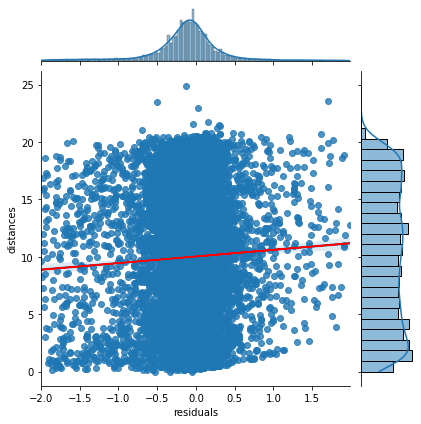

In [232]:
import seaborn as sns

sns.jointplot(x="residuals", y="distances", data=data2,kind='reg');
plt.plot(data2['residuals'],(slope*data2['residuals']+intercept),'r');
#result of the regression showed in red

* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

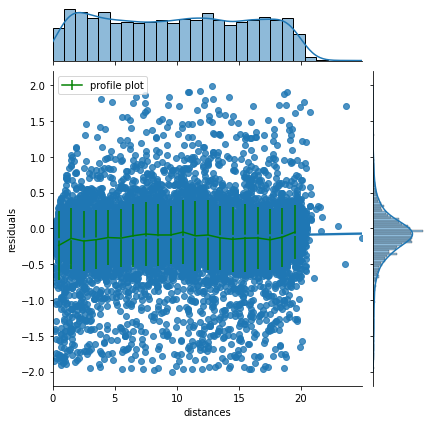

In [281]:
n_bin=20
x= np.zeros(n_bin)
y=np.zeros(n_bin)
erry=np.zeros(n_bin)
#x:
equidistant_list=np.linspace(0,20,n_bin+1)
x= (equidistant_list[1:]+equidistant_list[:-1])/2
residual_np=data2['residuals'][:].to_numpy()
dist_np= data2['distances'][:].to_numpy()

for minn, maxx, i in zip(equidistant_list[:-1], equidistant_list[1:],range(n_bin)):
    #y:
    y[i]=np.mean(residual_np[np.logical_and((dist_np>=minn),(dist_np<=maxx))])
    #erry:
    erry[i]=np.std( residual_np[np.logical_and((dist_np>=minn),(dist_np<=maxx))] )


a = sns.jointplot(x="distances", y="residuals", data=data2, kind='reg')
plt.errorbar(x,y,yerr=erry, label='profile plot', color='g');

a.ax_joint.legend()